# SIB KAGGLE PROJECT

In [1]:
#Imports
from utils.func import *
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

In [2]:
#First lets see the data!
#Train dataframe
train = pd.read_csv("data/train.csv",index_col="seq_id")
#Test dataframe
test = pd.read_csv("data/test.csv",index_col="seq_id")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")
print("Remove data_source")
train= train.drop(columns="data_source")
test= test.drop(columns="data_source")
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print("We want to predict tm values for test data")
print(train.describe())

Train data is divided in 31390 lines and 4 col
Test data is divided in 2413 lines and 3 col
Labels: ['protein_sequence', 'pH', 'data_source', 'tm']
Remove data_source
Train data is divided in 31390 lines and 3 col
Test data is divided in 2413 lines and 2 col
We want to predict tm values for test data
                 pH            tm
count  31104.000000  31390.000000
mean       6.892339     49.147337
std        1.612225     14.010089
min        1.990000     -1.000000
25%        7.000000     42.100000
50%        7.000000     48.000000
75%        7.000000     53.800000
max       64.900000    130.000000


In [3]:
update_train= pd.read_csv("/Users/André Silva/SIB_G4/Data/train_updates_20220929.csv",index_col="seq_id")
train= swap_ph_tm(train,update_train)

In [4]:
train

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6


In [5]:
print(train.isnull().sum().sort_values(ascending=False))
print(test.isnull().sum().sort_values(ascending=False))
#There are some missing values in train
#Data_source values are not that important

pH                  286
protein_sequence      0
tm                    0
dtype: int64
protein_sequence    0
pH                  0
dtype: int64


In [6]:
missing_data= train[train["pH"].isnull()]
missing_data

,protein_sequence,pH,tm
seq_id,,,
484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,84.0
6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,73.8
6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,85.5
6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,67.1
6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,83.2
...,...,...,...
28753,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,58.9
28754,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,59.4
28755,MVLKQRANYLGFLIVFFTAFLVEAVPIKRQSNSTVDSLPPLIPSRT...,NaN,57.8


In [7]:
train= train.drop((missing_data).index)
train
#Podemos remover também a data_source? Não deve de trazer nada de relevante para a analise dos dados

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5
...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6


In [8]:
print(f"Train data is divided in {train.shape[0]} lines and {train.shape[1]} col")
print(f"Test data is divided in {test.shape[0]} lines and {test.shape[1]} col")
print(f"Labels: {[labels for labels in train.columns]}")

Train data is divided in 28695 lines and 3 col
Test data is divided in 2413 lines and 2 col
Labels: ['protein_sequence', 'pH', 'tm']


In [9]:
train.describe()

,pH,tm
count,28695.000000,28695.000000
mean,6.872467,51.385604
std,0.793184,12.076609
min,1.990000,25.100000
25%,7.000000,43.700000
50%,7.000000,48.800000
75%,7.000000,54.600000
max,11.000000,130.000000


Next we will perform an unsupervised analysis of our data
For that we will need to obtain descriptors for our protein sequences 

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils.kmers import KMer_prot
from sklearn.preprocessing import StandardScaler
from propy import PyPro

In [12]:
train_array= np.array(train.loc[:,["protein_sequence"]])
train_array

array([['AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVGMIKDAGDDPDVTHGAEIQAFVRFASEDRLEGGEGVGVVTKPGLGVPVGEPAINPVPRRMIWEAVREVTERPLAVTIAIPGGEELAKKTLNPRLGILGGLSVLGTTGVVKPYSTSAFRMSVVQAVGVARANGLLEIAATTGGKSERFAQRLLPHLPEMAFIEMGDFVGDVLRAARKVGVEVVRVVGMIGKISKMADGKTMTHAAGGEVNLSLLLSLLKEAGASPKALKEAEGAATARRFLEIALEEGLELFFVNLVRLAQEKLQAYIGERPFVSVALTDFDEGRCLAAWPDREVYR'],
       ['AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS'],
       ['AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYATLGVAKNANGKDIKKAYYQLAKKYHPDTNKEDPDAGRKFQEVSEAYEVLSDEQKRREYDTYGQTAENIGRQGGGFPGGGAGGFGPEGFSQSWQFRSSIDPEELFRKIFGEGNFRTNSFDDFADSKFGFGQAQEMVMDLTFAQAARGVNKDVNVNVVDQCPKCAGTKCEPGTKPGRCQYCNGTGFETVSTGPFVMRSTCRYCQGTRQHIKYPCSECEGKGRTVQRRKVTVPVPAGIENGQTVRMQVGSKELFVTFRVERSDYFRREGADVHTDAAISLAQAVLGGTVRVQGVY

In [24]:
# kmer = KMer_prot()
# new_data = kmer.fit_transform(train_array)

KeyboardInterrupt: 

In [ ]:
# new_data= StandardScaler().fit_transform(new_data)
# new_data_mean= [np.mean(line) for line in new_data]
# print("There is a maximum of :",max(new_data_mean))
# print("There is a Minimum of :",min(new_data_mean))

KeyboardInterrupt: 

In [ ]:
# train["protein_descriptor"] = new_data_mean

In [13]:
di_peptide= CalculateDipeptideComposition(train_array)

In [14]:
di_dataframe= pd.DataFrame(di_peptide)

In [15]:
molecular_weight = Calculate_molecular_weight(train_array)
isoelectric_point = Calculate_isoelectric_point(train_array)
aromaticity = Calculate_aromaticity(train_array)
instability_index = Calculate_instability_index(train_array)

In [16]:
train["molecular_weight"]=molecular_weight
train["isoelectric_point"]=isoelectric_point
train["aromaticity"]=aromaticity
train["instability_index"]=instability_index

In [17]:
train

,protein_sequence,pH,tm,molecular_weight,isoelectric_point,aromaticity,instability_index
seq_id,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,36320.7244,6.109589,0.058651,28.389736
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,32837.9931,5.144349,0.041958,65.108392
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,53428.8034,9.032101,0.080483,35.089336
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,29475.5996,4.683840,0.071698,50.502264
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,158761.9814,5.917928,0.065472,45.668808
...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,61997.6230,8.466327,0.089253,48.604026
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,52637.6897,6.532244,0.087420,35.285096
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,14203.9225,5.271214,0.117188,44.198437


# Unsupervised machine learning

### K-Means

K-Means is a unsupervised machine learning algorithm used to group data into clusters based on similarities.
The goal of K-means is to partition a dataset into a specified number of clusters (k) in a way that minimizes the within-cluster sum of squares. Here we present the following steps to run this algotithm:

1. Randomly selecting k initial centroids (points in the dataset that represent the center of the clusters)
2. Data point assigned to the cluster corresponding to the nearest centroid
3. The centroids are then updated to be the mean of the points in their respective clusters

This process is repeated until the centroids no longer change, or a maximum number of iterations is reached (In this case we set a maximum number of iterations)

In [38]:
# train_set=train.loc[:,['pH',"molecular_weight","isoelectric_point","aromaticity","instability_index"]]
# train_set.plot(kind= "scatter",
#                 x="protein_descriptor",
#                 y= "pH",
#                 figsize=(10,7))
# plt.show

In [19]:
train_set=train.drop(["protein_sequence"],axis=1)

In [21]:
k=4
kmeans_train= KMeans(n_clusters=k,max_iter=1000)
kmeans_train.fit(train_set)
labels= kmeans_train.labels_
centroids= kmeans_train.cluster_centers_


In [22]:
y_predict= kmeans_train.fit_predict(train.loc[:,['pH',"molecular_weight","isoelectric_point","aromaticity","instability_index"]])
y_predict

array([0, 0, 2, ..., 0, 2, 2])

In [23]:
train["y_predict"]= y_predict
train

,protein_sequence,pH,tm,molecular_weight,isoelectric_point,aromaticity,instability_index,y_predict
seq_id,,,,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,36320.7244,6.109589,0.058651,28.389736,0
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,32837.9931,5.144349,0.041958,65.108392,0
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,53428.8034,9.032101,0.080483,35.089336,2
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,29475.5996,4.683840,0.071698,50.502264,0
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,158761.9814,5.917928,0.065472,45.668808,3
...,...,...,...,...,...,...,...,...
31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,51.8,61997.6230,8.466327,0.089253,48.604026,2
31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,52637.6897,6.532244,0.087420,35.285096,2
31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,64.6,14203.9225,5.271214,0.117188,44.198437,0


In [37]:
# kmeans_train.cluster_centers_
# df1 = train[train.y_predict==0]
# df2 = train[train.y_predict==1]
# df3 = train[train.y_predict==2]
# df4 = train[train.y_predict==3]

# plt.scatter(df1.pH,df1["molecular_weight"],df1["isoelectric_point"],df1["aromaticity"],df1["instability_index"],color='green')
# plt.scatter(df2.pH,df2.molecular_weight,df2.isoelectric_point,df2.aromaticity,df2.instability_index,color='red')
# plt.scatter(df3.pH,df3.molecular_weight,df3.isoelectric_point,df3.aromaticity,df3.instability_index,color='black')
# plt.scatter(df4.pH,df4.molecular_weight,df4.isoelectric_point,df4.aromaticity,df4.instability_index,color='blue')
# plt.scatter(kmeans_train.cluster_centers_[:,0],kmeans_train.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
# plt.legend()



InvalidIndexError: (array([    2,    21,    25, ..., 28691, 28693, 28694], dtype=int64),)

# PCA

[9.99829651e+01 1.70348562e-02]


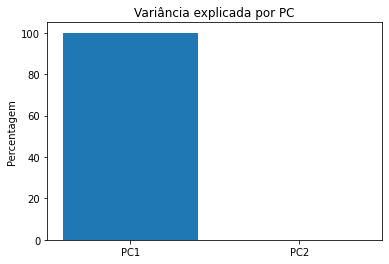

In [73]:
from sklearn.decomposition import PCA
n=2

pca_train= PCA(n_components=n)
pca_train.fit(train_set)
reduce=pca_train.transform(train_set)

print((pca_train.explained_variance_ratio_)*100)

plt.bar(range(n), pca_train.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1,n+1)])
plt.title("Variância explicada por PC")
plt.ylabel("Percentagem")
plt.show()


# t-SNE

In [74]:
from sklearn.manifold import TSNE

In [75]:
tsne = TSNE(n_components=2, n_iter=1000,perplexity=40)
points = tsne.fit_transform(train_set)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

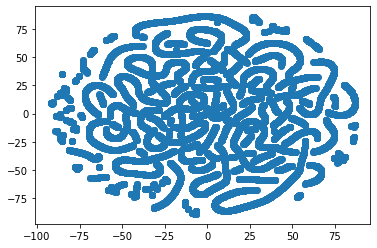

In [ ]:
plt.scatter(points[:,0],points[:,1])